In [1]:
# Import necessary library for studying the different models
import sys
sys.path.append('../')

from model import *
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import seaborn as sns
sns.set_theme()

# Tutorial

This notebook explores how to choose the parameters of interest on the MIMIC example, and explore how to measure potential bias reinforcement. It shows step by step how to:
1. Build the proposed amalgamation approach
2. Compute performance
3. Measure the influence (per group)
4. Measure the different metrics (per group)
5. Measure the percentage of amalgamation

In [2]:
data_set = "../data/triage_scenario_4bis.csv" # Opne data of interest 4bis corresponds to the biased scenario.
selective_labels = False # Is it a case of selective labels (only observe the outcome for patients filtered by nurse: D == 1)

### Data

In [3]:
# Open the data
triage = pd.read_csv(data_set, index_col = [0, 1])
covariates, target, nurses = triage.drop(columns = ['D', 'Y1', 'Y2', 'YC', 'nurse']), triage[['D', 'Y1', 'Y2', 'YC']], triage['nurse']

Split data in a 80% train, 20% test

In [4]:
cov_train, cov_test, tar_train, tar_test, nur_train, nur_test = train_test_split(covariates, target, nurses, test_size = 0.2, random_state = 42)

### Modelling

In [5]:
# Model's characteristics
params = {'layers': [[50]]} # If = [[]] equivalent to a simple logistic regression

In [6]:
def evaluate(predictions, p = 0.3):
    # Overall Performances
    print('Performance')
    for tar in ['Y1', 'Y2', 'YC', 'D']:
        print('{} - AUC: {:.3f}'.format(tar, roc_auc_score(tar_test[tar], predictions)))

        try:
            predictions = pd.Series(predictions, index = tar_test.index)
            bot = predictions.nsmallest(n = int(p * len(predictions)), keep = 'all').index
            female = covariates.loc[predictions.index].Group == 1
            bot_female = bot.intersection(female[female].index)
            bot_male = bot.intersection(female[~female].index)

            print('{} - Female TNR: {:.3f}'.format(tar, 1 - tar_test[tar].loc[bot_female].mean()))
            print('{} - Female PNR: {:.3f}'.format(tar, len(bot_female) / female.sum()))
            print()
        except:
            pass

##### 1. Train on decision

Similarly to `Triage - MIMIC.ipynb`, we first train a model and estimate the influence.

In [7]:
f_h = BinaryMLP(**params)
f_h = f_h.fit(cov_train, tar_train['D'], nur_train, platt_calibration = True)
predictions_d = f_h.predict(cov_test)
evaluate(predictions_d) 

Loss: 0.235: 100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


Performance
Y1 - AUC: 0.607
Y1 - Female TNR: 0.442
Y1 - Female PNR: 0.547

Y2 - AUC: 0.473
Y2 - Female TNR: 0.386
Y2 - Female PNR: 0.547

YC - AUC: 0.588
YC - Female TNR: 0.113
YC - Female PNR: 0.547

D - AUC: 0.967
D - Female TNR: 0.956
D - Female PNR: 0.547



This first model mimics the human decision. We measure the true negative rate and predicted rate in the protected group. A discrepancy between $f_h$ and $f_Y$ could indicate expert bias.

##### 2. Agreement computation 

In [8]:
# Fold evaluation of influences
folds, predictions, influence = influence_cv(BinaryMLP, cov_train, tar_train['D'], nur_train, params = params, l1_penalties = [0.001, 0.01, 0.1, 1])

Loss: 0.237: 100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


This step compute the influence of the training point in a cross validation fashion. One can then look at:
- Distribution of predictions
- Distribution of influences

/tmp/ipykernel_3341/3668459732.py:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  sns.histplot(x ='$f_H$', hue = 'Group', data = pd.concat([cov_train.Group.replace({0: 'Male', 1: 'Female'}), pred_series], 1))


<AxesSubplot:xlabel='$f_H$', ylabel='Count'>

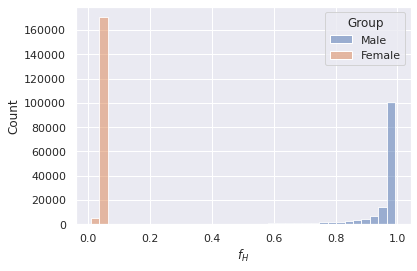

In [9]:
pred_series = pd.Series(predictions, index = cov_train.index, name = '$f_H$')
sns.histplot(x ='$f_H$', hue = 'Group', data = pd.concat([cov_train.Group.replace({0: 'Male', 1: 'Female'}), pred_series], 1))

Unexplained group differences is sign that experts might be biased against one group. Nonetheless, user should take into account domain specific expertise as distributions might differ (e.g. breast cancer might impact male differently and the physician decision might reflect this difference).

/tmp/ipykernel_3341/3579979505.py:3: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  pd.concat([cov_train.Group.replace({0: 'Male', 1: 'Female'}), inf_series], 1).groupby('Group').mean().T.plot.scatter('Female', 'Male')
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='Female', ylabel='Male'>

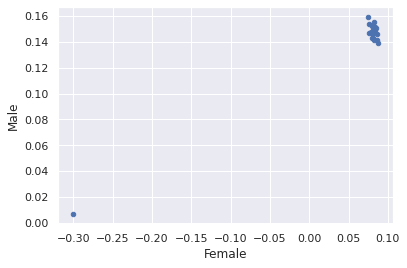

In [10]:
# Mean influence per group
inf_series = pd.DataFrame(influence.T, index = cov_train.index)
pd.concat([cov_train.Group.replace({0: 'Male', 1: 'Female'}), inf_series], 1).groupby('Group').mean().T.plot.scatter('Female', 'Male')

Outliers in this plot represent expert who have a strong impact in a different direction than all other experts. 

One can then compute the different metrics that aim to measure consensus.

In [11]:
# Compute metrics agreeability
center_metric, opposing_metric = compute_agreeability(influence, predictions)

In [12]:
# Analyze confident points
delta = 0.05 # Control which point to consider from a confience point of view

In [13]:
# Select points with high confidence
high_conf = (predictions > (1 - delta)) | (predictions < delta)

In the selected points, one can study the different metrics quantifying the consensus beteween expert obtained for each points.

/tmp/ipykernel_3341/3403321864.py:4: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  sns.histplot(x ='$m_1$', hue = 'Group', data = pd.concat([cov_train.Group.replace({0: 'Male', 1: 'Female'}), m1_series], 1)[high_conf], stat = "density")


<AxesSubplot:xlabel='$m_1$', ylabel='Density'>

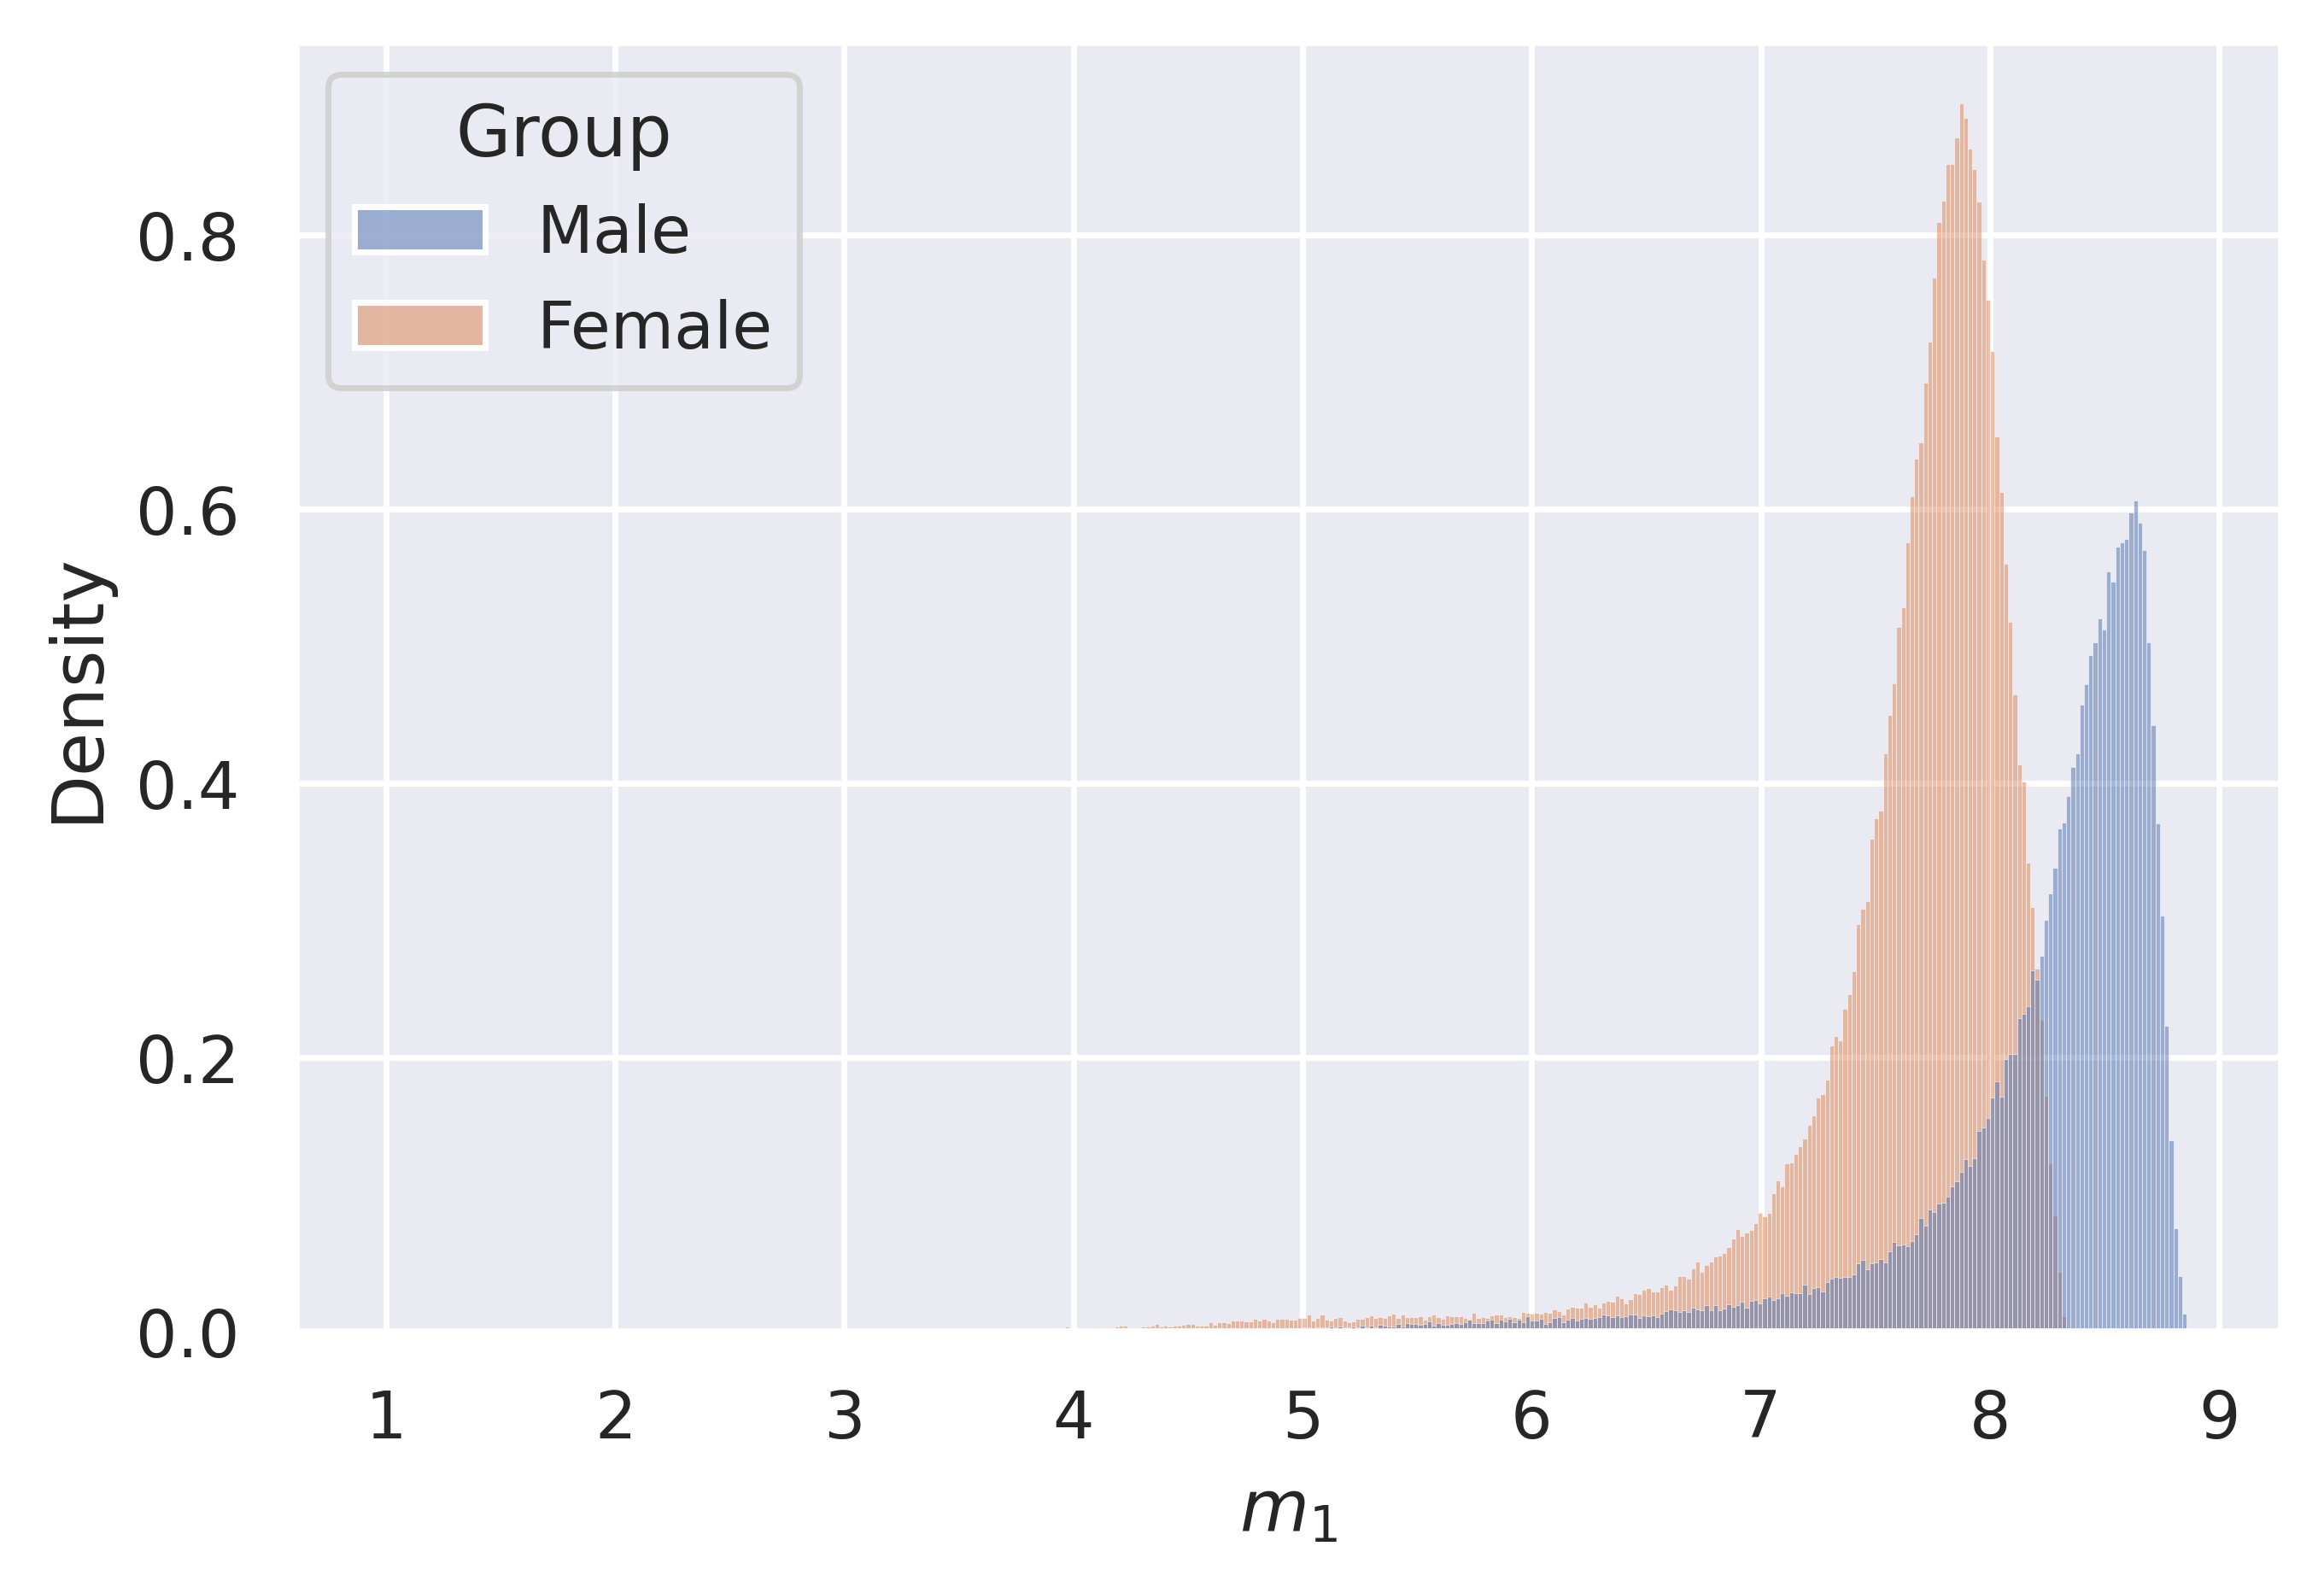

In [14]:
m1_series = pd.Series(center_metric, index = cov_train.index, name = '$m_1$')
sns.histplot(x ='$m_1$', hue = 'Group', data = pd.concat([cov_train.Group.replace({0: 'Male', 1: 'Female'}), m1_series], 1)[high_conf], stat = "density")

This first metric measures the **center of mass**: *higher the value, more experts agree*. In this scenario, note how the female distribution is shifted due to the bias of one expert. This shift indicates that less experts agree on this particular group. 

In this context choosing $\gamma_1$ at 6 or 7 allows to capture a large amount of the agreement. 

/tmp/ipykernel_3341/3431672905.py:3: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  sns.histplot(x ='$m_2$', hue = 'Group', data = pd.concat([cov_train.Group.replace({0: 'Male', 1: 'Female'}), m2_series], 1)[high_conf], stat = "density")


<AxesSubplot:xlabel='$m_2$', ylabel='Density'>

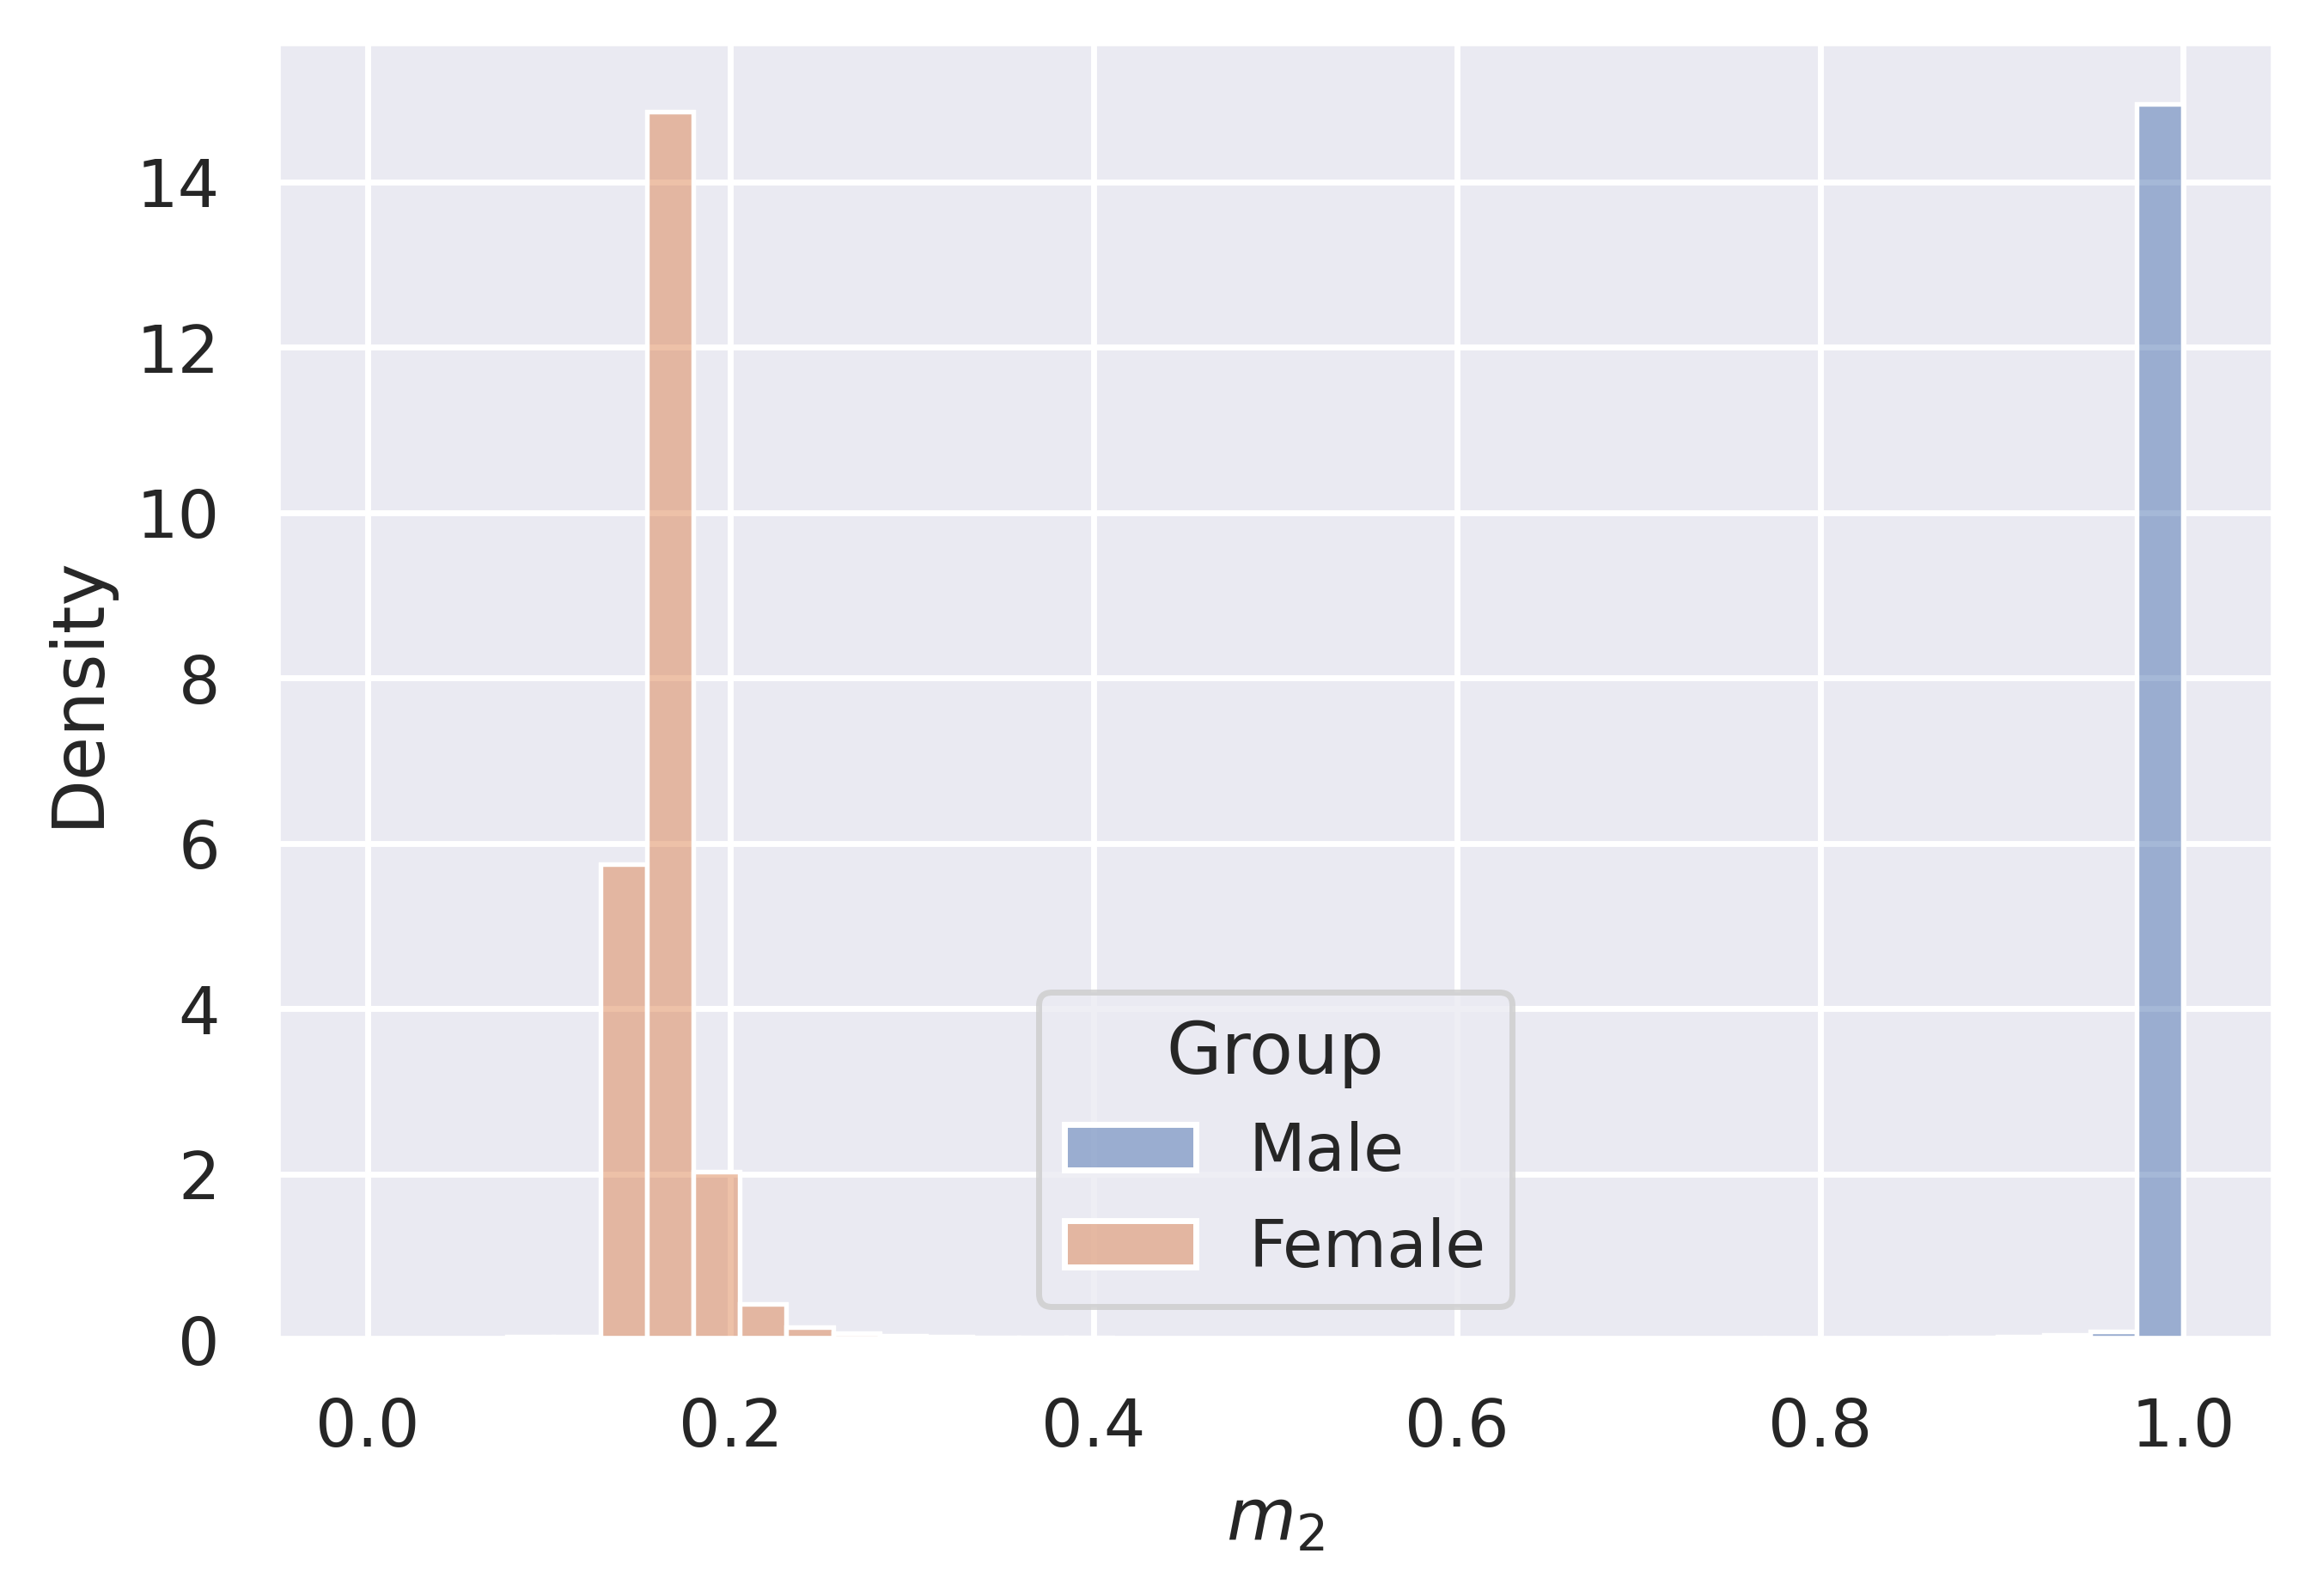

In [15]:
m2_series = pd.Series(opposing_metric, index = cov_train.index, name = '$m_2$')
sns.histplot(x ='$m_2$', hue = 'Group', data = pd.concat([cov_train.Group.replace({0: 'Male', 1: 'Female'}), m2_series], 1)[high_conf], stat = "density")

This second metric measures how **aligned is the influence**: *larger it is, more expert are going in the same direction*.

Here, the shift in the female distribution shows that a small set of expert is driving the decision for this group. To be conservative, one would want to correct for this non consensus, i.e. any threshold $\gamma_2 > 0.4$ would ignore these points.

In [16]:
# Amalgation parameters choice
pi_1 = 6 # Control criterion on centre mass metric
pi_2 = 0.8 # Control criterion on opposing metric
pi_3 = 0.002 # On flatness

Following this choice, one can amalgamte the human decision and the observed outcome.

In [17]:
# Apply criteria on amalgamation
flat_influence = (np.abs(influence) > pi_3).sum(0) == 0
high_agr = (((center_metric > pi_1) & (opposing_metric > pi_2)) | flat_influence) & high_conf
high_agr_correct = ((predictions - tar_train['D']).abs() < delta) & high_agr
print("This choice of parameters leads to an amalgamation of : {:.2f} % of the data".format(100 * np.mean(high_agr_correct)))

This choice of parameters leads to an amalgamation of : 33.48 % of the data


In [18]:
# Create amalgamated labels
tar_train['Ya'] = tar_train['Y1']# Initialize as human decision
tar_train.loc[high_agr_correct, 'Ya'] = tar_train['D'][high_agr_correct] # Change the point to amalgamate

In [19]:
index_amalg = ((tar_train['D'] == 1) | high_agr_correct) if selective_labels else tar_train['D'].isin([0, 1]) # Retrain the model on the set of observed points
print("Use: {:.2f} % of data".format(100 * index_amalg.mean()))

Use: 100.00 % of data


##### 3. Updated model

In [20]:
f_A = BinaryMLP(**params)
f_A = f_A.fit(cov_train[index_amalg], tar_train[index_amalg]['Ya'], nur_train[index_amalg])
predictions_amal = f_A.predict(cov_test)
evaluate(predictions_amal)

Loss: 0.339: 100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


Performance
Y1 - AUC: 0.848
Y1 - Female TNR: 0.716
Y1 - Female PNR: 0.360

Y2 - AUC: 0.376
Y2 - Female TNR: 0.274
Y2 - Female PNR: 0.360

YC - AUC: 0.783
YC - Female TNR: 0.172
YC - Female PNR: 0.360

D - AUC: 0.745
D - Female TNR: 0.959
D - Female PNR: 0.360



Comparison to the $f_Y$ model may warn of the reinforcement of biases.

##### 4. Train on observed data

In [21]:
index_observed = (tar_train['D'] == 1) if selective_labels else tar_train['D'].isin([0, 1])

In [22]:
f_Y = BinaryMLP(**params)
f_Y = f_Y.fit(cov_train[index_observed], tar_train['Y1'][index_observed], nur_train[index_observed])
predictions = f_Y.predict(cov_test)
evaluate(predictions)

Loss: 0.408: 100%|██████████| 10/10 [00:20<00:00,  2.04s/it]


Performance
Y1 - AUC: 0.932
Y1 - Female TNR: 0.821
Y1 - Female PNR: 0.278

Y2 - AUC: 0.257
Y2 - Female TNR: 0.227
Y2 - Female PNR: 0.278

YC - AUC: 0.777
YC - Female TNR: 0.179
YC - Female PNR: 0.278

D - AUC: 0.486
D - Female TNR: 0.958
D - Female PNR: 0.278



-----------

##### 5. Hybrid alternative

- Leverage human model in the amalgamation set
- Leverage outcome model on non amalgamation set

Models need to be retrain on their respective subsets and calibrated to ensure to mix

In [23]:
predictions = predictions_d.copy()

In [24]:
# Compute which test points are part of A for test set
predictions_test, influence_test = influence_estimate(BinaryMLP, cov_train, tar_train['D'], nur_train, cov_test, params = params, l1_penalties = [0.001, 0.01, 0.1, 1])
center_metric, opposing_metric = compute_agreeability(influence_test, predictions_test)
flat_influence_test = (np.abs(influence_test) > pi_3).sum(0) == 0
high_conf_test = (predictions_test > (1 - delta)) | (predictions_test < delta)
high_agr_test = (((center_metric > pi_1) & (opposing_metric > pi_2)) | flat_influence_test) & high_conf_test
high_agr_correct_test = ((predictions_test - tar_test['D']).abs() < delta) & high_agr_test

Loss: 0.236: 100%|██████████| 10/10 [00:20<00:00,  2.00s/it]


In [25]:
# Retrain a model on non almagamation only and calibrate: Rely on observed
f_hyb = BinaryMLP(**params)
f_hyb = f_hyb.fit(cov_train[index_observed], tar_train['Y1'][index_observed], nur_train[index_observed], platt_calibration = True)
predictions[~high_agr_correct_test] = f_hyb.predict(cov_test.loc[~high_agr_correct_test])
evaluate(predictions)

Loss: 0.408: 100%|██████████| 10/10 [00:28<00:00,  2.85s/it]


Performance
Y1 - AUC: 0.798
Y1 - Female TNR: 0.723
Y1 - Female PNR: 0.365

Y2 - AUC: 0.406
Y2 - Female TNR: 0.252
Y2 - Female PNR: 0.365

YC - AUC: 0.762
YC - Female TNR: 0.168
YC - Female PNR: 0.365

D - AUC: 0.794
D - Female TNR: 0.957
D - Female PNR: 0.365

